# ELEC0134 - Applied Machine Learning Systems Assignment 2019/2020
## Task A1: Gender Detection

In this notebook, we are going to detect gender either male or female from the *celeba* dataset:
1. Pre-processing the images using feature extractions technique to obtain facial landmarks
2. Fit the model to the training data
3. Model hyperparameter tuning for kernel parameter in Support Vector Classifiers 
4. Test the performances of the classifier
5. Build a pipeline for reusability

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

%matplotlib inline

## 1) *Pre-processing*
### Feature extraction
We can extract relevant features from the images by using face detector from dlib library which consists of a combination of the Histogram of Oriented Gradients (HOG) feature with a linear classifier, an image pyramid,and sliding window detection scheme. 

The image below visualizes the location of 68 facial regions that dlib detects:

![facial_landmarks_68.jpg](facial_landmarks_68.jpg)

1) Jaw: [1,17] &emsp; 2)Right eyebrown: [18,22] &emsp; 3) Left eyebrown: [23,27] &emsp; 4) Nose: [28,36] &emsp; 4) Right eye: [37,42] &emsp; 5) Left eye: [43,48] &emsp; 6) Mouth: [49,68]

We can obtain these features given an image by simply calling the ***extract_features_labels()*** function in the landmarks.py file. 

Using these features is optional, since there is a variety of facial landmarks detectors you could choose from. Also the same dlib framework can be used to train other facial landmark detectors or custom shape predictors.

### Feature Extraction Function

In [83]:
os.chdir('A1')

In [84]:
os.getcwd()

'D:\\UCL\\4th Year\\Applied Machine Learning System\\Part 1\\Assignment\\AMLS_assignment\\A1'

In [85]:
# import libraries
import os
from keras.preprocessing import image
import cv2
import dlib

# PATH TO ALL IMAGES
global basedir, image_paths, target_size

# Modified the directory
os.chdir('..')
AMLS_dir = os.path.abspath(os.curdir)
basedir = os.path.join(AMLS_dir,'Datasets')
celeba_dir = os.path.join(basedir,'celeba')
img_dir = os.path.join(celeba_dir,'img')
labels_filename = 'labels.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

### Convert facial landmarks into Numpy array

In [86]:
# how to find frontal human faces in an image using 68 landmarks.  These are points on the face such as the corners of the mouth, along the eyebrows, on the eyes, and so forth.

# The face detector we use is made using the classic Histogram of Oriented
# Gradients (HOG) feature combined with a linear classifier, an image pyramid,
# and sliding window detection scheme.  The pose estimator was created by
# using dlib's implementation of the paper:
# One Millisecond Face Alignment with an Ensemble of Regression Trees by
# Vahid Kazemi and Josephine Sullivan, CVPR 2014
# and was trained on the iBUG 300-W face landmark dataset (see https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/):
#     C. Sagonas, E. Antonakos, G, Tzimiropoulos, S. Zafeiriou, M. Pantic.
#     300 faces In-the-wild challenge: Database and results.
#     Image and Vision Computing (IMAVIS), Special Issue on Facial Landmark Localisation "In-The-Wild". 2016.

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

### Bounding box to match the faces

In [87]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

### Extract landmarks at face region

In [88]:
def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

### Extract the facial landmarks and gender label all images in *celeba* dataset

In [89]:
def extract_features_labels(images_dir, celeba_dir, labels_filename):
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
    It also extracts the gender label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        gender_labels:      an array containing the gender label (male=0 and female=1) for each image in
                            which a face was detected
        error_img:          error detecting 68 landmark points in the images due to non-frontal faces
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    labels_file = open(os.path.join(celeba_dir, labels_filename), 'r')
    lines = labels_file.readlines()
    gender_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]}
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        error_img = []
        for img_path in image_paths:
            file_name= img_path.split('.')[0].split('\\')[-1]
            
            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(gender_labels[file_name])
            else:
                error_img.append(file_name)
                

    landmark_features = np.array(all_features)
    gender_labels = (np.array(all_labels) + 1)/2 # simply converts the -1 into 0, so male=0 and female=1
    return landmark_features, gender_labels, error_img

### Example of an extracted images

D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\celeba\img\100.jpg


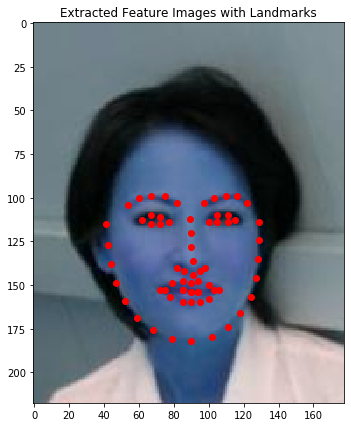

In [91]:
ex_img = os.path.join(img_dir, '100.jpg')
img = image.img_to_array(image.load_img(ex_img,
                               target_size = None,
                               interpolation = 'bicubic'))
img_features, _ = run_dlib_shape(img)
print(ex_img)

# Load image using cv2
actual_img = cv2.imread(ex_img)
fig = plt.figure(figsize = (7,7))
fig_plot = plt.imshow(actual_img)
plt.title('Extracted Feature Images with Landmarks')
plt.scatter(img_features[:,0], img_features[:,1], c = 'r')

### Non-frontal face images detection
Gender detection does not work well with some images due to non-frontal face images. The feature extraction function will error for these images and should be discarded during the model training.

In [92]:
landmarks, genders, error_landmarks = extract_features_labels(img_dir, celeba_dir, labels_filename)
print('5000 images with features: ' + str(landmarks.shape[0]))
print('5000 images with labels: ' + str(genders.shape[0]))

# Print the images with failed landmarks detection
print('# of error images ' + str(len(error_landmarks)))
print('Error images with associated title: ')
print(error_landmarks)

5000 images with features: 4798
5000 images with labels: 4798
# of error images 202
Error images with associated title: 
['1015', '1045', '1109', '1119', '1153', '1162', '1183', '119', '123', '1254', '1297', '1305', '1337', '1343', '136', '137', '1400', '143', '1468', '1479', '148', '149', '1505', '1522', '153', '1532', '158', '1602', '1605', '1641', '1649', '165', '1651', '1666', '1676', '1703', '1793', '1815', '187', '1877', '1939', '1945', '1956', '198', '1994', '1997', '2', '201', '2012', '2013', '2040', '2060', '2110', '2145', '219', '2201', '2213', '223', '2248', '2261', '2267', '2285', '2294', '2314', '2344', '2345', '2347', '239', '2416', '2447', '2480', '2486', '2512', '2582', '2605', '2622', '2631', '2696', '2727', '2728', '2819', '2828', '2851', '2919', '292', '2961', '2971', '2975', '3', '3012', '3048', '3054', '3107', '3130', '3135', '3142', '315', '3168', '3171', '3197', '3199', '3211', '3257', '3291', '330', '3319', '3382', '3399', '3454', '3492', '35', '3514', '3564', '

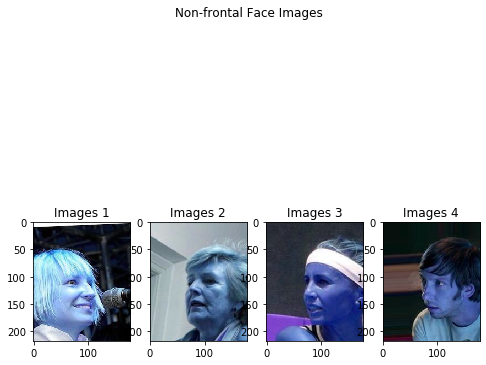

In [94]:
# Display the first 4 non-frontal images using cv2
error_img = [os.path.join(img_dir, i + '.jpg') for i in error_landmarks[:4]]
fig = plt.figure(figsize = (8,8))
fig.suptitle('Non-frontal Face Images')
for index in range (4):
    sub_fig = fig.add_subplot(1, 4, index+1)
    error_fig = plt.imshow(cv2.imread(error_img[index]))
    sub_fig.set_title("Images " + str(index+1))
    
plt.show()

### Load the *landmarks* and *genders* as training data

In [95]:
def get_data(X, Y):
    Y = np.array([Y, -(Y - 1)]).T
    X, Y = shuffle(X, Y)
    tr_X, te_X, tr_Y, te_Y = train_test_split(X, Y, train_size = 0.7, random_state = 42)
    
    # Reshape training and test X into (n_samples, n_features)
    tr_X = tr_X.reshape(tr_X.shape[0], tr_X.shape[1]*tr_X.shape[2])
    te_X = te_X.reshape(te_X.shape[0], te_X.shape[1]*te_X.shape[2])
    
    # Unzipped training and test Y from (n_samples,) into (n_samples)
    tr_Y = list(zip(*tr_Y))[0]
    te_Y = list(zip(*te_Y))[0]
    
    return tr_X, te_X, tr_Y, te_Y

tr_feature, te_feature, tr_label, te_label = get_data(landmarks, genders)
print(tr_feature.shape)
print(te_feature.shape)

(3358, 136)
(1440, 136)


## 2) Fit the SVM model to the training data
Fit 3 different Support Vector Classifier (SVC) such as polynomial, rbf and linear kernel to the training data

In [96]:
# Linear kernel SVM
def SVM_linear(x_train, y_train, x_test):
    model = SVC(kernel = 'linear', gamma = 'auto')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

# Polynomial kernel SVM
def SVM_poly(x_train, y_train, x_test, d):
    model = SVC(kernel = 'poly', degree = d, gamma = 'auto')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

# Radial basis function kernel SVM
def SVM_rbf(x_train, y_train, x_test):
    model = SVC(kernel = 'rbf', gamma = 'auto')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred 

# Result of classifier for linear SVM
y_pred = SVM_linear(tr_feature, tr_label, te_feature)
print('Linear kernel SVC')
print('Accuracy of classifier: ', accuracy_score(te_label,y_pred))
print('Confusion matrix: \n', confusion_matrix(te_label,y_pred))
print(classification_report(te_label,y_pred))

# Result of classifier for polynomial SVM
y_pred2 = SVM_poly(tr_feature, tr_label, te_feature, 3)
print('Polynomial kernel SVC')
print('Accuracy of classifier: ', accuracy_score(te_label,y_pred2))
print('Confusion matrix: \n', confusion_matrix(te_label,y_pred2))
print(classification_report(te_label,y_pred2))
              
# Result of classifier for RBF SVM
y_pred3 = SVM_rbf(tr_feature, tr_label, te_feature)
print('RBF kernel SVC')
print('Accuracy of classifier: ', accuracy_score(te_label,y_pred3))
print('Confusion matrix: \n', confusion_matrix(te_label,y_pred3))
print(classification_report(te_label,y_pred3))

Linear kernel SVC
Accuracy of classifier:  0.9145833333333333
Confusion matrix: 
 [[666  59]
 [ 64 651]]
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       725
         1.0       0.92      0.91      0.91       715

    accuracy                           0.91      1440
   macro avg       0.91      0.91      0.91      1440
weighted avg       0.91      0.91      0.91      1440

Polynomial kernel SVC
Accuracy of classifier:  0.9090277777777778
Confusion matrix: 
 [[667  58]
 [ 73 642]]
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       725
         1.0       0.92      0.90      0.91       715

    accuracy                           0.91      1440
   macro avg       0.91      0.91      0.91      1440
weighted avg       0.91      0.91      0.91      1440

RBF kernel SVC
Accuracy of classifier:  0.8291666666666667
Confusion matrix: 
 [[568 157]
 [ 89 626]]
              precision    rec

## 3) Hyperparameter tuning for SVC (Support Vector Classifiers)
### SVC with RBF kernel
**Note:** You should not scale the data since we are interested in plotting the support vectors. <br />
1. RBF kernel: \begin{align}e^{(-\gamma||x-x'||^2)} \end{align} 
Hyperparameter are ***C*** and ***gamma*** 

In [99]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

param_RBF = {'C': stats.uniform(0.1, 10),
             'gamma': stats.uniform(0.001, 0.01),
             'kernel': ['rbf']}

### SVC with polynomial kernel
2. Polynomial kernel: \begin{align} (\gamma <x,x'> +r)^d\end{align} 
Hyperparameter are ***C***, ***gamma***, ***coefficient*** and ***degree***

In [100]:
param_poly = {'C': stats.uniform(0.1, 10),
              'coef0': stats.uniform(1, 5),
              'degree': stats.uniform(1, 5),
              'kernel': ['poly']}

### SVC with linear kernel
3. Linear kernel: \begin{align} <x,x'> \end{align}
Hyperparameter is only ***C***

In [108]:
param_linear = {'C': stats.uniform(0.1, 10),
                'kernel': ['linear']}

### Randomized search cross validation
RandomizedSearchCV available in scikit-learn library can be used to estimate the optimum hyperparameter of SVM kernel by sampling the paramater according to the probability distribute. Then, applying K-fold cross validation on training data. In this assignment, consider using only RBF, linear and polynomial kernel. **Note that linear kernel is differnt to the polynomial kernel of degree = 1 because polynomial kernel has default coeffient coef0=1 but linear coef0=0**

In [109]:
def SVC_randomSearch(X, y, param_kernel):
    # number of jobs = -1 mean using all processors
    rand_search = RandomizedSearchCV(SVC(), param_kernel, n_iter=10, n_jobs=-1, refit=True, verbose=3)
    rand_search.fit(X, y)
    
    return rand_search.best_params_, rand_search.best_estimator_

# Obtaining optimum hyperparameters and classifier for different kernel
print('Tuning optimum hyper parameter for SVM with polynomial kernel...')
polySVC_param, clf_polySVC = SVC_randomSearch(tr_feature, tr_label, param_poly)

print('Tuning optimum hyper parameter for SVM with RBF kernel...')
rbfSVC_param, clf_rbfSVC = SVC_randomSearch(tr_feature, tr_label, param_RBF)

print('Tuning optimum hyper parameter for SVM with linear kernel...')
linearSVC_param, clf_linearSVC = SVC_randomSearch(tr_feature, tr_label, param_linear)

# Display optimum hyparameters for SVC kernel
print('Optimum hyperparameters for polynomial kernel: ')
print(polySVC_param)
print('Optimum hyperparameters for rbf kernel: ')
print(rbfSVC_param)
print('Optimum hyperparameters for linear kernel: ')
print(linearSVC_param)

Tuning optimum hyper parameter for SVM with polynomial kernel...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.7min finished


Tuning optimum hyper parameter for SVM with RBF kernel...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.0s finished


Tuning optimum hyper parameter for SVM with linear kernel...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 22.9min finished


Optimum hyperparameters for polynomial kernel: 
{'C': 2.3136582708919664, 'coef0': 1.25518376494162, 'degree': 3.782501688765892, 'kernel': 'poly'}
Optimum hyperparameters for rbf kernel: 
{'C': 6.3658561362871495, 'gamma': 0.0018691362049223174, 'kernel': 'rbf'}
Optimum hyperparameters for linear kernel: 
{'C': 0.616649192148414, 'kernel': 'linear'}


### Plotting the learning curve to diagnose model validation
Using the code available in scikit-learn website <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html">Click here</a>
<br />
Learning curve below can be used to select the optimum training examples for training best classifier.

In [126]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=3,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### Learning curve for polynomial kernel SVC

[learning_curve] Training set sizes: [ 268  872 1477 2081 2686]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 out of 250 | elapsed:   12.2s remaining:   24.6s
[Parallel(n_jobs=-1)]: Done 167 out of 250 | elapsed:   21.3s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   32.0s finished


<module 'matplotlib.pyplot' from 'c:\\users\\user\\anaconda3\\envs\\env_dlib\\lib\\site-packages\\matplotlib\\pyplot.py'>

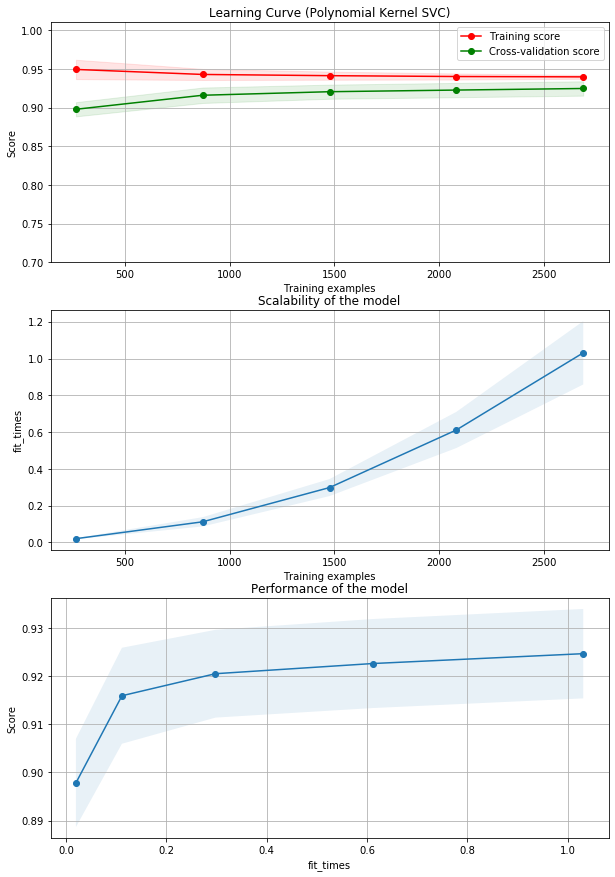

In [133]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot learning curve for polynomial kernel SVC
title = "Learning Curve (Polynomial Kernel SVC)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(clf_polySVC, title, tr_feature, tr_label, axes=axes, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

### Learning curve for rbf kernel SVC

[learning_curve] Training set sizes: [ 268  872 1477 2081 2686]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 out of 250 | elapsed:   24.9s remaining:   50.2s
[Parallel(n_jobs=-1)]: Done 167 out of 250 | elapsed:   50.4s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.3min finished


<module 'matplotlib.pyplot' from 'c:\\users\\user\\anaconda3\\envs\\env_dlib\\lib\\site-packages\\matplotlib\\pyplot.py'>

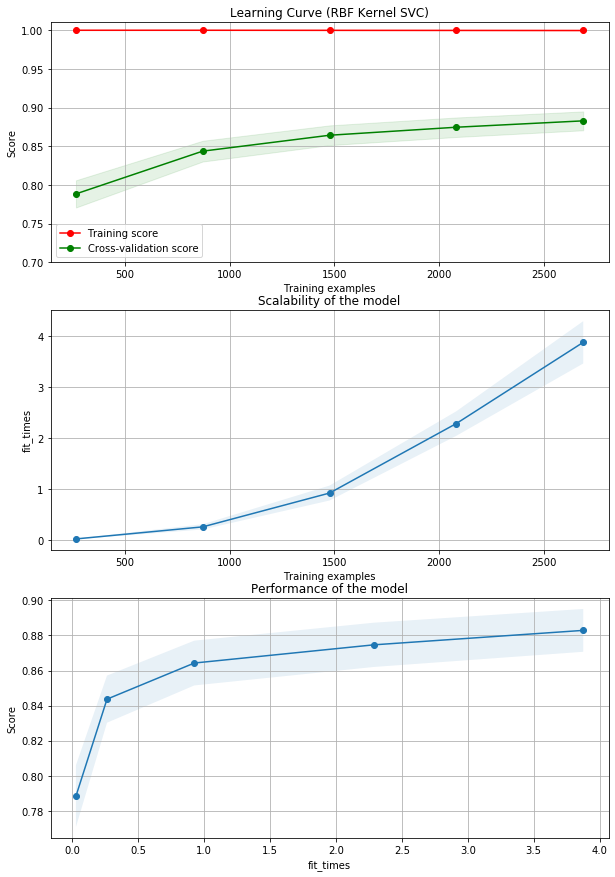

In [134]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot learning curve for RBF kernel SVC
title = "Learning Curve (RBF Kernel SVC)"
plot_learning_curve(clf_rbfSVC, title, tr_feature, tr_label, axes=axes, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

### Learning curve for linear kernel SVC

[learning_curve] Training set sizes: [ 268  872 1477 2081 2686]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 out of 250 | elapsed:  1.6min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done 167 out of 250 | elapsed:  3.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.3min finished


<module 'matplotlib.pyplot' from 'c:\\users\\user\\anaconda3\\envs\\env_dlib\\lib\\site-packages\\matplotlib\\pyplot.py'>

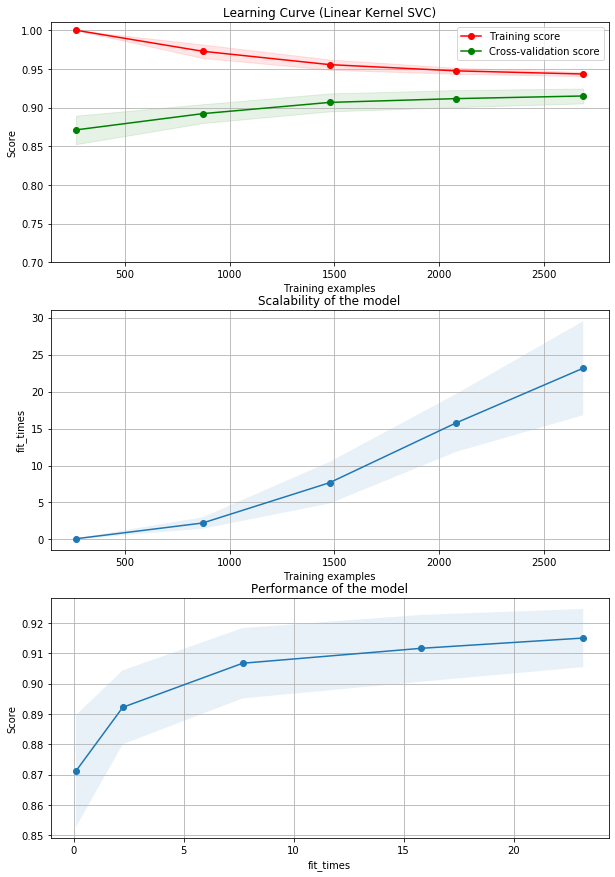

In [135]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot learning curve for RBF kernel SVC
title = "Learning Curve (Linear Kernel SVC)"
plot_learning_curve(clf_linearSVC, title, tr_feature, tr_label, axes=axes, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

## 5) Test the performances of the classifier
1. Fitting the best model to the test data
2. Display accuracy score, confusion matrix and report for different kernel
3. Plot receiving operating characteristics (ROC) curve for justifying classifier performance

Non-normalized confusion matrix
[[666  59]
 [ 64 651]]
Normalized confusion matrix
[[0.92 0.08]
 [0.09 0.91]]
Accuracy of classifier:  0.9145833333333333
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       725
         1.0       0.92      0.91      0.91       715

    accuracy                           0.91      1440
   macro avg       0.91      0.91      0.91      1440
weighted avg       0.91      0.91      0.91      1440



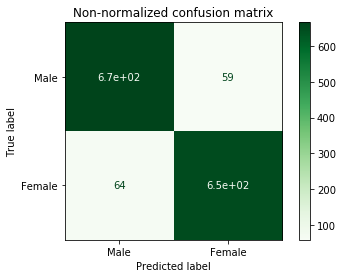

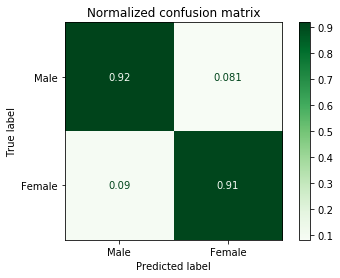

Non-normalized confusion matrix
[[646  79]
 [ 89 626]]
Normalized confusion matrix
[[0.89 0.11]
 [0.12 0.88]]
Accuracy of classifier:  0.8833333333333333
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       725
         1.0       0.89      0.88      0.88       715

    accuracy                           0.88      1440
   macro avg       0.88      0.88      0.88      1440
weighted avg       0.88      0.88      0.88      1440



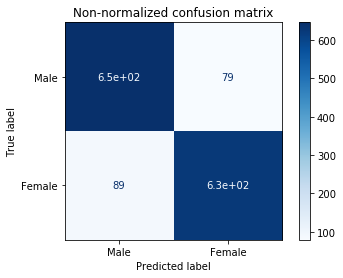

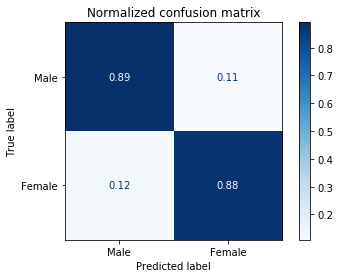

Non-normalized confusion matrix
[[667  58]
 [ 65 650]]
Normalized confusion matrix
[[0.92 0.08]
 [0.09 0.91]]
Accuracy of classifier:  0.9145833333333333
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       725
         1.0       0.92      0.91      0.91       715

    accuracy                           0.91      1440
   macro avg       0.91      0.91      0.91      1440
weighted avg       0.91      0.91      0.91      1440



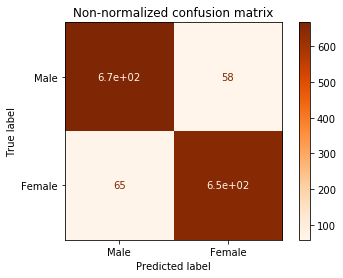

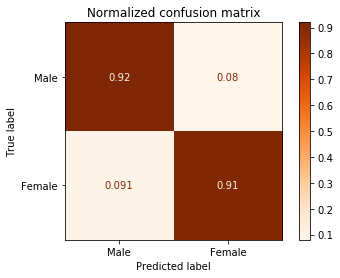

In [137]:
from sklearn.metrics import plot_confusion_matrix

# Function to display confusion matrix
def disp_confusion_matrix(classifier, cmap, X_test, y_test):
    np.set_printoptions(precision=2)
    pred = classifier.predict(X_test)

    # Plot confusion matrix for polynomial kernel
    titles_options = [("Non-normalized confusion matrix", None),
                      ("Normalized confusion matrix", 'true')]
    class_names = ['Male', 'Female']
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=cmap,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
        
    print('Accuracy of classifier: ', accuracy_score(y_test,pred))
    print(classification_report(y_test, pred))
    plt.show()
    
disp_confusion_matrix(clf_polySVC, plt.cm.Greens, te_feature, te_label)
disp_confusion_matrix(clf_rbfSVC, plt.cm.Blues, te_feature, te_label)
disp_confusion_matrix(clf_linearSVC, plt.cm.Oranges, te_feature, te_label)

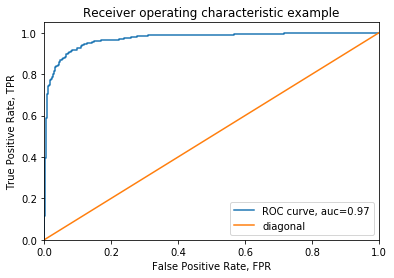

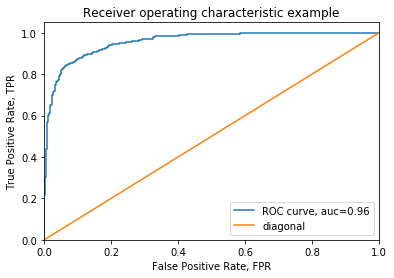

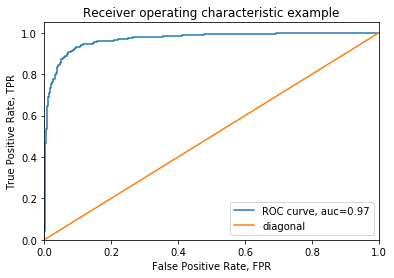

In [112]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def plot_ROC(classifier, X_test, y_test):
    # Learn to predict each class against the other
    y_score = classifier.decision_function(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test,  y_score)
    auc = roc_auc_score(y_test, y_score)
    
    plt.plot(fpr,tpr,label="ROC curve, auc="+str(round(auc,2)))
    plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate, FPR')
    plt.ylabel('True Positive Rate, TPR')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
plot_ROC(clf_polySVC, te_feature, te_label)
plot_ROC(clf_rbfSVC, te_feature, te_label)
plot_ROC(clf_linearSVC, te_feature, te_label)

### 5) Building the SVM model pipeline

### Import Miguel Rodriguez test dataset

Non-normalized confusion matrix
[[462  27]
 [ 49 432]]
Normalized confusion matrix
[[0.94 0.06]
 [0.1  0.9 ]]
Accuracy of classifier:  0.9216494845360824
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       489
         1.0       0.94      0.90      0.92       481

    accuracy                           0.92       970
   macro avg       0.92      0.92      0.92       970
weighted avg       0.92      0.92      0.92       970



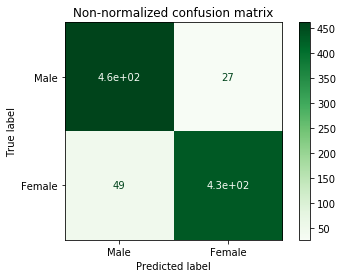

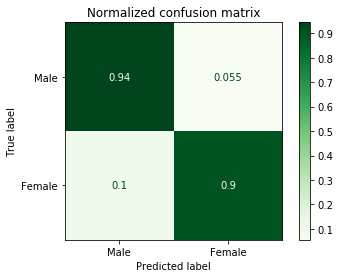

Non-normalized confusion matrix
[[442  47]
 [ 65 416]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.14 0.86]]
Accuracy of classifier:  0.8845360824742268
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89       489
         1.0       0.90      0.86      0.88       481

    accuracy                           0.88       970
   macro avg       0.89      0.88      0.88       970
weighted avg       0.89      0.88      0.88       970



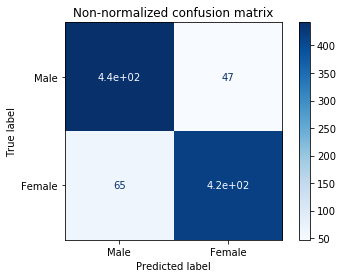

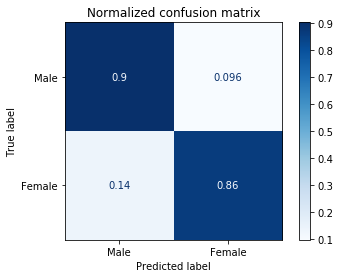

Non-normalized confusion matrix
[[460  29]
 [ 60 421]]
Normalized confusion matrix
[[0.94 0.06]
 [0.12 0.88]]
Accuracy of classifier:  0.9082474226804124
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       489
         1.0       0.94      0.88      0.90       481

    accuracy                           0.91       970
   macro avg       0.91      0.91      0.91       970
weighted avg       0.91      0.91      0.91       970



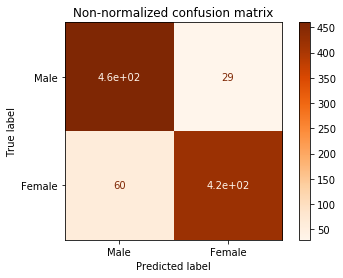

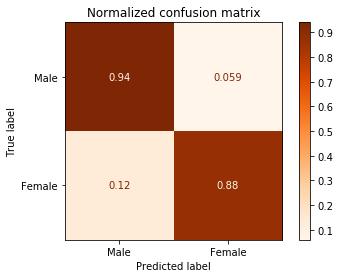

In [123]:
# Modified the directory to test dataset
celeba_test_dir = os.path.join(basedir,'celeba_test')
images_test_dir = os.path.join(celeba_test_dir,'img')
labels_test_filename = 'labels.csv'

# Extract the new test dataset
landmarks_test, genders_test, _ = extract_features_labels(images_test_dir, celeba_test_dir, labels_test_filename)

# Load data for classifier
def get_test_data(X, Y):
    Y = np.array([Y, -(Y - 1)]).T
    
    # Reshape training and test X into (n_samples, n_features)
    te_X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
    
    # Unzipped training and test Y from (n_samples,) into (n_samples)
    te_Y = list(zip(*Y))[0]
    
    return te_X, te_Y

new_feature, new_label = get_test_data(landmarks_test, genders_test)

disp_confusion_matrix(clf_polySVC, plt.cm.Greens, new_feature, new_label)
disp_confusion_matrix(clf_rbfSVC, plt.cm.Blues, new_feature, new_label)
disp_confusion_matrix(clf_linearSVC, plt.cm.Oranges, new_feature, new_label)

### Loading Zlatan Ibrahimovic

D:\UCL\4th Year\Applied Machine Learning System\Part 1\Assignment\AMLS_assignment\Datasets\celeba\img\100.jpg


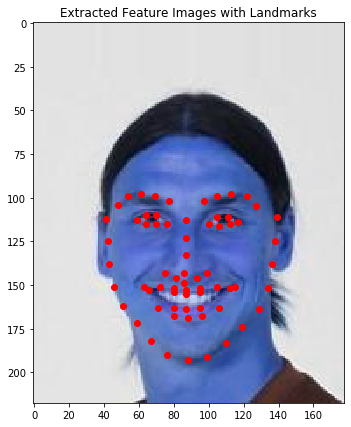

In [122]:
test_img = os.path.join(images_test_dir, '100.jpg')
load_test_img = image.img_to_array(image.load_img(test_img,
                               target_size = None,
                               interpolation = 'bicubic'))
img_test_features, _ = run_dlib_shape(load_test_img)
print(ex_img)

# Load image using cv2
actual_test_img = cv2.imread(test_img)
fig = plt.figure(figsize = (7,7))
fig_plot = plt.imshow(actual_test_img)
plt.title('Extracted Feature Images with Landmarks')
plt.scatter(img_test_features[:,0], img_test_features[:,1], c = 'r')

### Plotting the confusion matrix for the extra test dataset

### Extra: Visualizing SVM kernel

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
test_reduced = pca.fit_transform(te_feature)
print(test_reduced)

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.2):
    """Create a mesh of points to plot in
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_SVM(pca_data, clf, y_test):
    classify = clf.fit(pca_data, y_test)
    
    X0, X1 = pca_data[:, 0], pca_data[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    fig, ax = plt.subplots(figsize=(8,8))
    fig.patch.set_facecolor('white')
    cdict1={0:'lime',1:'deeppink'}

    Y_tar_list = np.array(y_test).tolist()
    yl1= [int(target1) for target1 in Y_tar_list]
    labels1=yl1

    labl1={0:'Male',1:'Female'}
    marker1={0:'*',1:'d'}
    alpha1={0:.8, 1:0.5}

    for l1 in np.unique(labels1):
        ix1=np.where(labels1==l1)
        ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=40, facecolors='none', 
               edgecolors='navy', label='Support Vectors')

    plot_contours(ax, classify, xx, yy,cmap='seismic', alpha=0.4)
    plt.legend(fontsize=15)

    plt.xlabel("1st Principal Component",fontsize=14)
    plt.ylabel("2nd Principal Component",fontsize=14)

    plt.show()
    
plot_SVM(test_reduced, clf_polySVC, te_label)
plot_SVM(test_reduced, clf_rbfSVC, te_label)
plot_SVM(test_reduced, clf_linearSVC, te_label)